In [1]:
from azureml.core import Workspace, Dataset

# Load the workspace
ws = Workspace.from_config()

# Load the tabular dataset by name
dataset = Dataset.get_by_name(ws, name='SolarPanel2')  # Make sure name matches exactly

# Convert to pandas DataFrame
df = dataset.to_pandas_dataframe()

# Check the first few rows
print(df.head())


{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe'}
{'infer_column_types': 'False', 'activity': 'to_pandas_dataframe', 'activityApp': 'TabularDataset'}
            timestamp  solar_generation_kw  energy_usage_kw  temperature_c  \
0 2023-01-01 00:00:00                  0.0         1.566908      13.033271   
1 2023-01-01 01:00:00                  0.0         1.727401      14.327366   
2 2023-01-01 02:00:00                  0.0         1.380186      15.533271   
3 2023-01-01 03:00:00                  0.0         1.248715      16.568805   
4 2023-01-01 04:00:00                  0.0         1.150028      17.363398   

   humidity_percent  cloud_cover_percent  precipitation_mm  wind_speed_kmh  \
0         79.610154            42.431953               0.0        8.488832   
1         68.232761            36.552824               0.0       13.919697   
2         75.491026            45.917359               0.0       13.245515   
3         72.116130            49.934605            

Shape of dataset: (17544, 7)

Missing values:
 timestamp              0
solar_generation_kw    0
energy_usage_kw        0
daylight_hours         0
hour                   0
dayofweek              0
month                  0
dtype: int64

Summary statistics:
        solar_generation_kw  energy_usage_kw  daylight_hours          hour  \
count         17544.000000     17544.000000    17544.000000  17544.000000   
mean              2.513860         1.015012        6.287096     11.500000   
std               2.757656         0.379684        6.586029      6.922384   
min               0.000000         0.500000        0.000000      0.000000   
25%               0.000000         0.671822        0.000000      5.750000   
50%               0.000000         0.994488        0.000000     11.500000   
75%               4.916669         1.327104       13.120923     17.250000   
max               9.115951         2.099319       15.999963     23.000000   

          dayofweek         month  
count  17544.

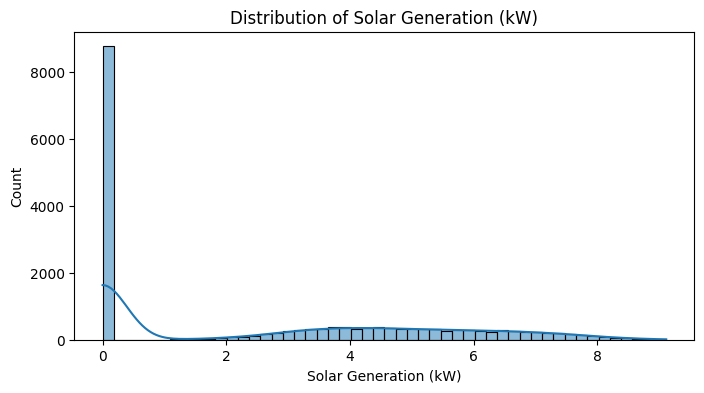

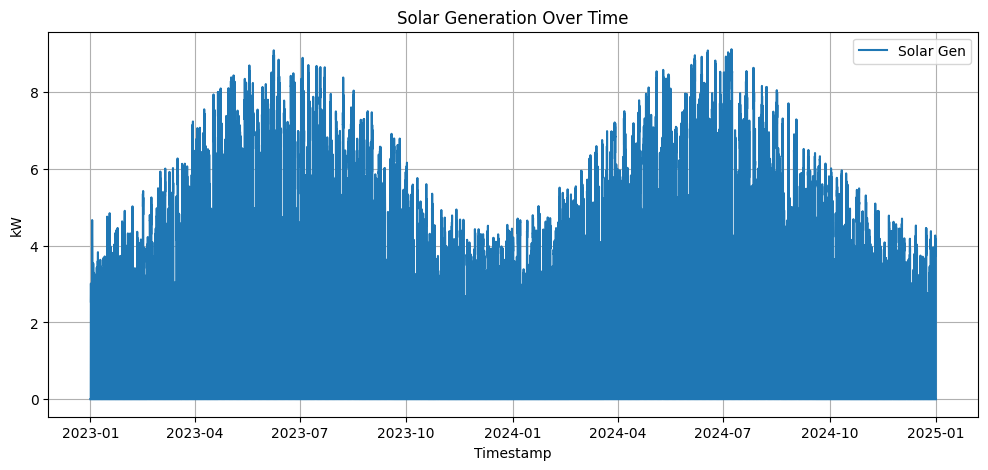

/tmp/ipykernel_3688/473586179.py:52: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.lineplot(x='hour', y='solar_generation_kw', data=df.groupby('hour').mean().reset_index())


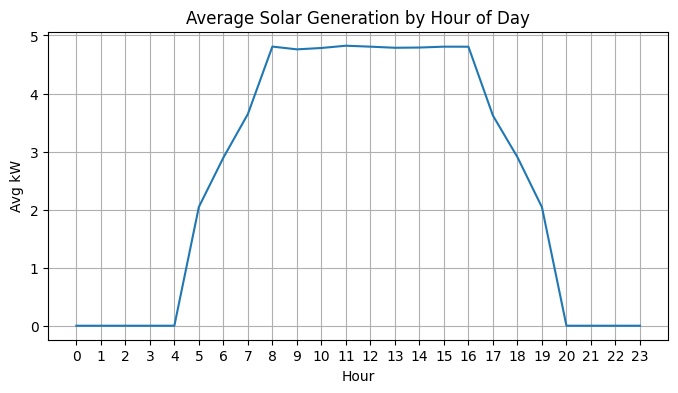

/tmp/ipykernel_3688/473586179.py:62: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='coolwarm')


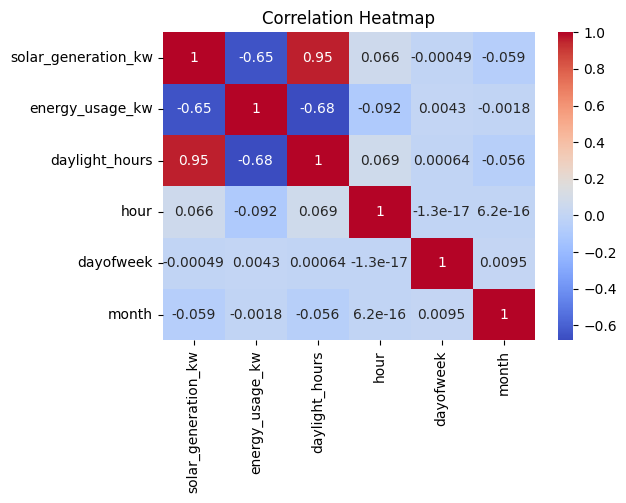

In [2]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('solar_data.csv')

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Drop unnecessary columns
df.drop(columns=[
    'temperature_c',
    'humidity_percent',
    'cloud_cover_percent',
    'precipitation_mm',
    'wind_speed_kmh'
], inplace=True)

# Create time-based features
df['hour'] = df['timestamp'].dt.hour
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# --- EDA Starts Here ---

# 1. Basic info
print("Shape of dataset:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nSummary statistics:\n", df.describe())

# 2. Distribution of target
plt.figure(figsize=(8, 4))
sns.histplot(df['solar_generation_kw'], bins=50, kde=True)
plt.title('Distribution of Solar Generation (kW)')
plt.xlabel('Solar Generation (kW)')
plt.ylabel('Count')
plt.show()

# 3. Solar generation over time
plt.figure(figsize=(12, 5))
plt.plot(df['timestamp'], df['solar_generation_kw'], label='Solar Gen')
plt.title('Solar Generation Over Time')
plt.xlabel('Timestamp')
plt.ylabel('kW')
plt.grid(True)
plt.legend()
plt.show()

# 4. Average solar generation by hour of day
plt.figure(figsize=(8, 4))
sns.lineplot(x='hour', y='solar_generation_kw', data=df.groupby('hour').mean().reset_index())
plt.title('Average Solar Generation by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Avg kW')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

# 5. Correlation heatmap (on remaining features)
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Create classification target
df['solar_active'] = (df['solar_generation_kw'] > 0.1).astype(int)

# Drop the original solar_generation_kw and any other irrelevant columns
df_model = df.drop(columns=['solar_generation_kw', 'timestamp'])

# Features and target
X = df_model.drop(columns='solar_active')
y = df_model['solar_active']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression()
model.fit(X_train_scaled, y_train)


LogisticRegression()

Accuracy: 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1755
           1       1.00      1.00      1.00      1754

    accuracy                           1.00      3509
   macro avg       1.00      1.00      1.00      3509
weighted avg       1.00      1.00      1.00      3509


Confusion Matrix:
 [[1755    0]
 [   0 1754]]


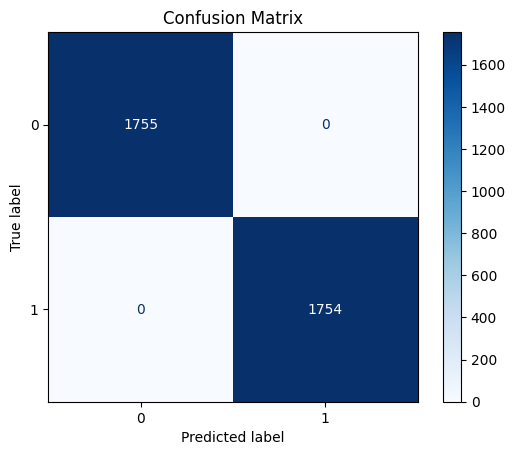

In [4]:
y_pred = model.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [9]:
import pandas as pd

# Simulated historical data from X_test
history_df = pd.DataFrame(X_test, columns=X.columns).copy()
history_df['solar_active'] = y_test.values

import matplotlib.pyplot as plt

def predict_realtime(hour, energy_usage_kw, daylight_hours, dayofweek, month, retrain = False):
    global history_df

    # Prepare new input
    new_data = pd.DataFrame([{
        'hour': hour,
        'energy_usage_kw': energy_usage_kw,
        'daylight_hours': daylight_hours,
        'dayofweek': dayofweek,
        'month': month
    }])[X.columns]

    # Scale and predict
    new_scaled = scaler.transform(new_data)
    prediction = model.predict(new_scaled)[0]
    new_data['solar_active'] = prediction

    # Append to history
    history_df = pd.concat([history_df, new_data], ignore_index=True)

    if retrain:
        print("\n🔁 Retraining model with updated history...")
        X_new = history_df.drop(columns='solar_active')
        y_new = history_df['solar_active']

        # Refit scaler and model
        scaler.fit(X_new)
        X_scaled = scaler.transform(X_new)

        model.fit(X_scaled, y_new)
        print("✅ Retraining completed.")

    # Display last 7 + new
    display_df = history_df.tail(7)
    print("\n📊 Last 7 Records + New Prediction:")
    print(display_df)

    # Print prediction
    print(f"\n🔮 Prediction: Solar is {'ACTIVE ☀️' if prediction == 1 else 'INACTIVE 🌙'}")

    # Estimate solar generation
    plot_df = display_df.copy()
    plot_df['estimated_kW'] = plot_df.apply(
        lambda row: row['energy_usage_kw'] if row['solar_active'] == 1 else 0, axis=1
    )

    # Plot estimated output
    plt.figure(figsize=(10, 4))
    plt.plot(plot_df.index, plot_df['estimated_kW'], marker='o', color='orange')
    plt.title('Estimated Solar Generation (Last 8 + New Input)')
    plt.xlabel('Entry')
    plt.ylabel('Estimated kW')
    plt.grid(True)
    plt.xticks(plot_df.index)
    plt.show()

        # ---- Final summary output ----
    today_output = energy_usage_kw if prediction == 1 else 0
    print(f"\n📌 Today expected output is: {today_output:.2f} kW")

    # ✅ Return last 6 estimated solar generation values as an array
    return plot_df['estimated_kW'].tail(6).to_numpy()






🔁 Retraining model with updated history...
✅ Retraining completed.

📊 Last 7 Records + New Prediction:
      energy_usage_kw  daylight_hours  hour  dayofweek  month  solar_active
3503         1.205395       15.844519    19          0      6             1
3504         1.271924        0.000000    20          1      2             0
3505         1.437004        0.000000     1          1      8             0
3506         0.590721       12.275210    14          6      3             1
3507         1.224208        0.000000     3          0      8             0
3508         0.500000       14.461138    14          6      8             1
3509         1.200000       12.500000    14          2      5             1

🔮 Prediction: Solar is ACTIVE ☀️


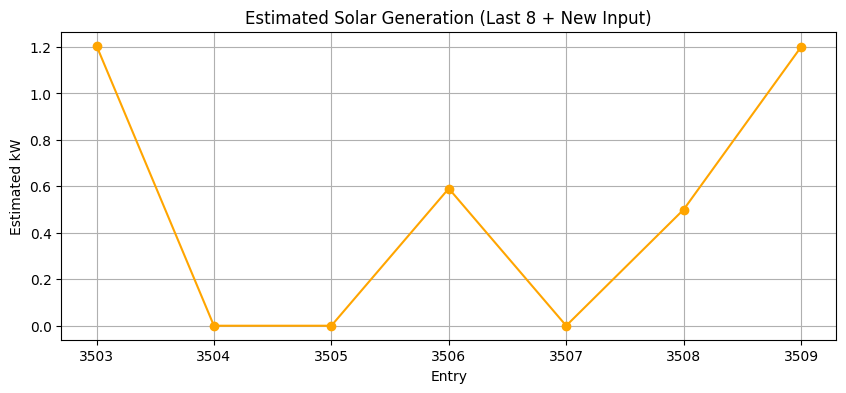


📌 Today expected output is: 1.20 kW


array([0.        , 0.        , 0.59072059, 0.        , 0.5       ,
       1.2       ])

In [10]:
predict_realtime(
    hour=14,
    energy_usage_kw=1.2,
    daylight_hours=12.5,
    dayofweek=2,
    month=5,
    retrain = True
)


In [7]:
import joblib

joblib.dump(model, "model.pkl")
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']